## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'approx1e5-pastis-wavelet-gray' # size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/wavelet/approx1e5/gray'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
else:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

In [5]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:818: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:40<00:00, 2470.10it/s]


Layer 3


100%|██████████| 100000/100000 [00:50<00:00, 1980.71it/s]


Layer 4


100%|██████████| 100000/100000 [00:50<00:00, 1998.62it/s]


Layer 5


100%|██████████| 100000/100000 [00:50<00:00, 1995.85it/s]


Layer 6


100%|██████████| 100000/100000 [00:49<00:00, 2006.64it/s]


Layer 7


100%|██████████| 100000/100000 [00:50<00:00, 1990.74it/s]


Layer 8


100%|██████████| 100000/100000 [00:52<00:00, 1887.79it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,1830.934600,1652.097695,2023.443611,2.933956,1.846394,4.126087,3180.0
3,587.781860,556.332090,620.660589,2.604501,2.026208,3.270645,12720.0
4,164.606740,154.984480,174.518847,3.278817,2.623241,4.093913,50880.0
5,37.863530,35.388520,40.433692,4.789256,3.843992,5.925404,203520.0
6,7.493805,6.929792,8.083942,6.740129,5.245897,8.892204,814080.0
7,1.386997,1.272397,1.509542,9.084314,7.002164,12.550997,3256320.0
8,0.215883,0.196152,0.238341,12.285479,8.522738,23.484665,13025280.0


## Initial Grid Search and Hypothesis Test Plots

####
Layer  2


100%|██████████| 55966/55966 [00:12<00:00, 4417.84it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 3180, Without approximation : 3180.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


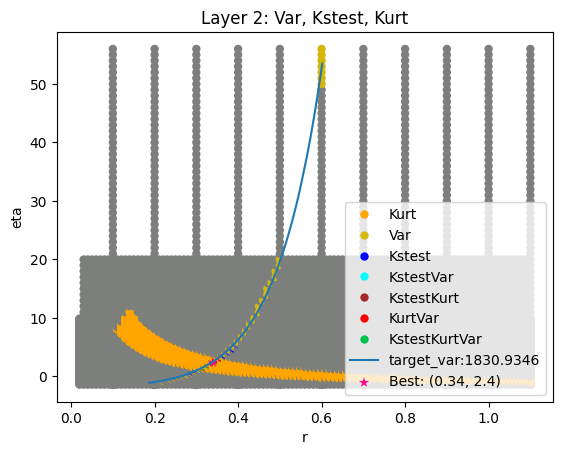

####
Layer  3


100%|██████████| 55966/55966 [00:27<00:00, 2016.52it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 12720, Without approximation : 12720.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


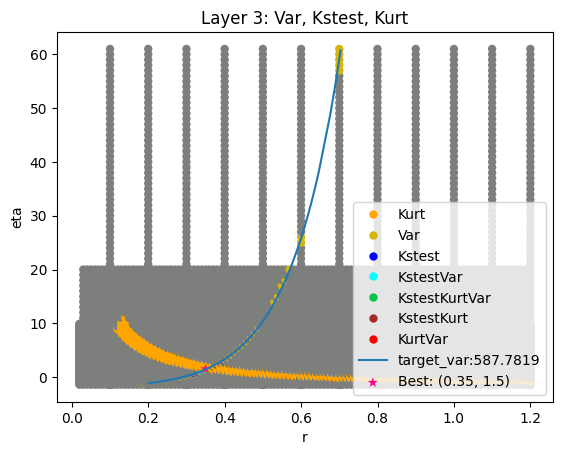

####
Layer  4


100%|██████████| 55966/55966 [01:47<00:00, 520.92it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 50880, Without approximation : 50880.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


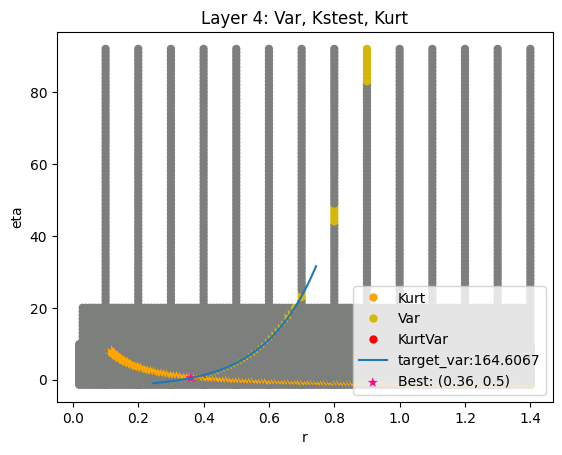

####
Layer  5


100%|██████████| 55966/55966 [03:21<00:00, 277.74it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 203520.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


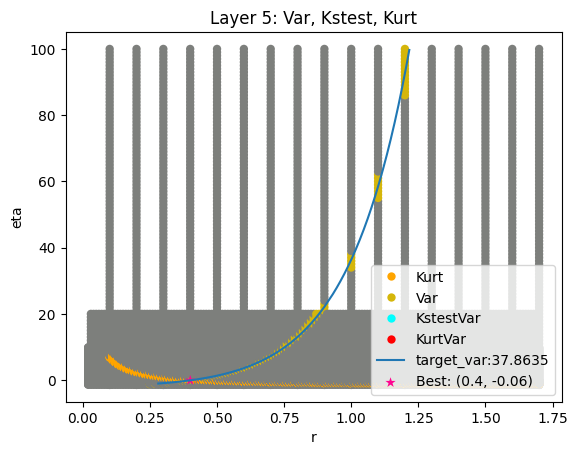

####
Layer  6


100%|██████████| 55966/55966 [03:18<00:00, 282.26it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 814080.0


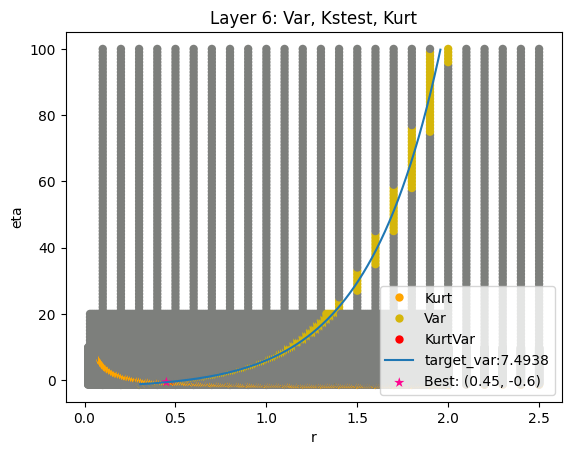

####
Layer  7


100%|██████████| 55966/55966 [03:23<00:00, 274.57it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 3256320.0


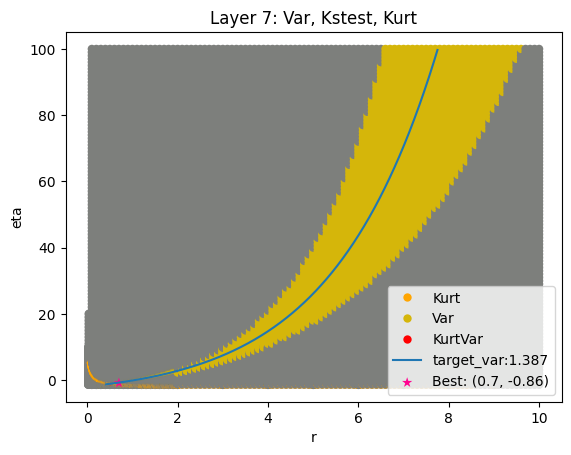

####
Layer  8


100%|██████████| 55966/55966 [03:25<00:00, 272.09it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 13025280.0


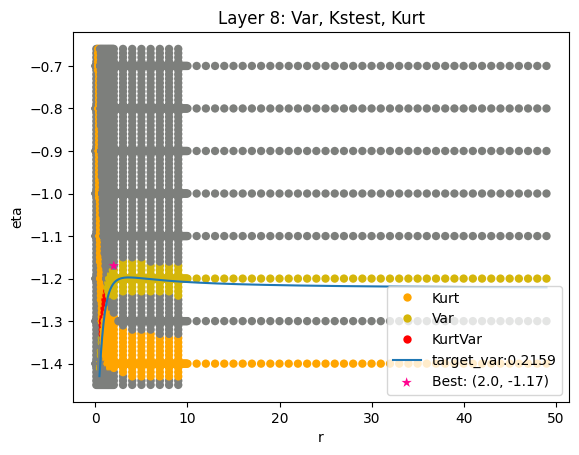

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,
2,1830.934600,1652.097695,2023.443611,2.933956,1.846394,4.126087,3180.0,0.34,2.40,0.017569,0.024030
3,587.781860,556.332090,620.660589,2.604501,2.026208,3.270645,12720.0,0.35,1.50,0.006195,0.012029
4,164.606740,154.984480,174.518847,3.278817,2.623241,4.093913,50880.0,0.36,0.50,0.006368,0.006018
5,37.863530,35.388520,40.433692,4.789256,3.843992,5.925404,203520.0,0.40,-0.06,0.001846,0.003010
6,7.493805,6.929792,8.083942,6.740129,5.245897,8.892204,814080.0,0.45,-0.60,0.006140,0.001505
7,1.386997,1.272397,1.509542,9.084314,7.002164,12.550997,3256320.0,0.70,-0.86,0.009293,0.000753
8,0.215883,0.196152,0.238341,12.285479,8.522738,23.484665,13025280.0,2.00,-1.17,0.033516,0.000376


In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = master_df.loc[group, 'obs_var'],
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

        # Optional: Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
            best_params_eta0.append(best_param_eta0[0])
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            best_params_eta0.append(master_df.loc[group, 'initial_r'])
    master_df['best_r_eta0'] = best_params_eta0
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 6113.03it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 1967.98it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 524.42it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 279.64it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 277.80it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 288.95it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 287.75it/s]

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
layer,,,,,,,,,,,,,
2,1830.934600,1652.097695,2023.443611,2.933956,1.846394,4.126087,3180.0,0.34,2.40,0.017569,0.024030,0.049518,0.25
3,587.781860,556.332090,620.660589,2.604501,2.026208,3.270645,12720.0,0.35,1.50,0.006195,0.012029,0.032488,0.27
4,164.606740,154.984480,174.518847,3.278817,2.623241,4.093913,50880.0,0.36,0.50,0.006368,0.006018,0.015027,0.32
5,37.863530,35.388520,40.433692,4.789256,3.843992,5.925404,203520.0,0.40,-0.06,0.001846,0.003010,0.004988,0.41
6,7.493805,6.929792,8.083942,6.740129,5.245897,8.892204,814080.0,0.45,-0.60,0.006140,0.001505,0.020233,0.63
7,1.386997,1.272397,1.509542,9.084314,7.002164,12.550997,3256320.0,0.70,-0.86,0.009293,0.000753,0.050050,6.00
8,0.215883,0.196152,0.238341,12.285479,8.522738,23.484665,13025280.0,2.00,-1.17,0.033516,0.000376,0.195805,6.10


## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2
(0.331, 2.38), 450 of 861
(0.333, 2.46), 500 of 861
(0.336, 2.33), 550 of 861
(0.338, 2.41), 600 of 861
(0.34, 2.49), 650 of 861
(0.343, 2.36), 700 of 861
(0.345, 2.44), 750 of 861
(0.348, 2.31), 800 of 861
(0.35, 2.39), 850 of 861


100%|██████████| 861/861 [00:00<00:00, 6189.93it/s]


Finding Minimum after computing 861 CDFs
Iter 1 layer 2 best parameters: ((0.34, 2.42), 0.016924686081207396)


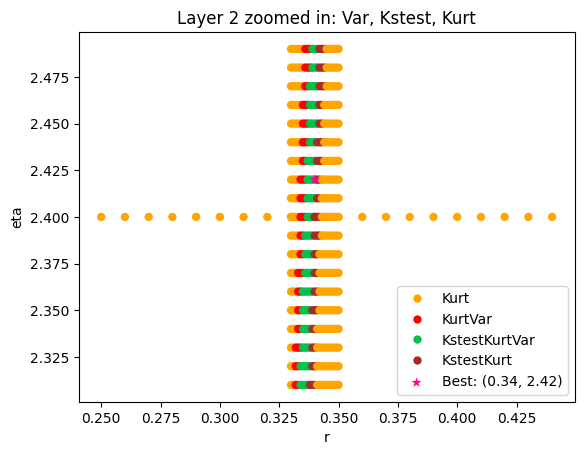

Layer 3
(0.34, 1.48), 450 of 882
(0.342, 1.56), 500 of 882
(0.345, 1.43), 550 of 882
(0.347, 1.51), 600 of 882
(0.349, 1.59), 650 of 882
(0.352, 1.46), 700 of 882
(0.354, 1.54), 750 of 882
(0.357, 1.41), 800 of 882
(0.359, 1.49), 850 of 882


100%|██████████| 882/882 [00:00<00:00, 2115.20it/s]


Finding Minimum after computing 882 CDFs
Iter 1 layer 3 best parameters: ((0.353, 1.56), 0.005071898707147748)


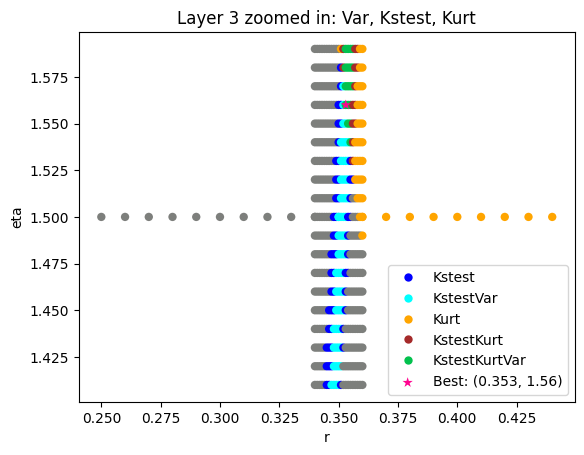

Layer 4
(0.351, 0.49), 450 of 840
(0.353, 0.59), 500 of 840
(0.356, 0.49), 550 of 840
(0.358, 0.59), 600 of 840
(0.361, 0.49), 650 of 840
(0.363, 0.59), 700 of 840
(0.366, 0.49), 750 of 840
(0.368, 0.59), 800 of 840


100%|██████████| 840/840 [00:01<00:00, 557.10it/s]


Finding Minimum after computing 840 CDFs
Iter 1 layer 4 best parameters: ((0.361, 0.53), 0.004837235235096049)


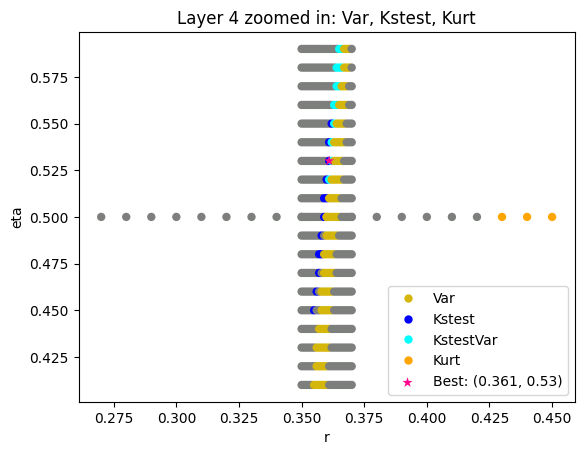

Layer 5
(0.31, -0.061), 450 of 820
(0.33, -0.051), 500 of 820
(0.36, -0.061), 550 of 820
(0.38, -0.051), 600 of 820
(0.41, -0.061), 650 of 820
(0.43, -0.051), 700 of 820
(0.46, -0.061), 750 of 820
(0.48, -0.051), 800 of 820


100%|██████████| 820/820 [00:02<00:00, 291.17it/s]


Finding Minimum after computing 820 CDFs
Iter 1 layer 5 best parameters: ((0.4, -0.061), 0.0018058458020765444)


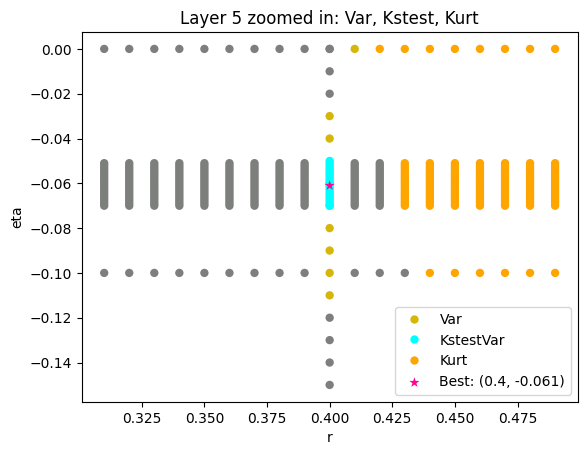

Layer 6
(0.441, -0.61), 450 of 840
(0.443, -0.51), 500 of 840
(0.446, -0.61), 550 of 840
(0.448, -0.51), 600 of 840
(0.451, -0.61), 650 of 840
(0.453, -0.51), 700 of 840
(0.456, -0.61), 750 of 840
(0.458, -0.51), 800 of 840


100%|██████████| 840/840 [00:03<00:00, 269.90it/s]


Finding Minimum after computing 840 CDFs
Iter 1 layer 6 best parameters: ((0.458, -0.57), 0.004686824381217092)


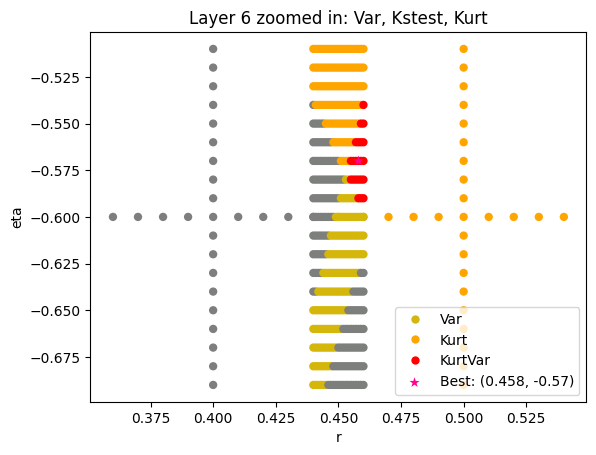

Layer 7
(0.61, -0.862), 450 of 840
(0.63, -0.854), 500 of 840
(0.66, -0.867), 550 of 840
(0.68, -0.859), 600 of 840
(0.7, -0.851), 650 of 840
(0.73, -0.864), 700 of 840
(0.75, -0.856), 750 of 840
(0.78, -0.869), 800 of 840


100%|██████████| 840/840 [00:03<00:00, 270.37it/s]


Finding Minimum after computing 840 CDFs
Iter 1 layer 7 best parameters: ((0.72, -0.852), 0.008731144662884938)


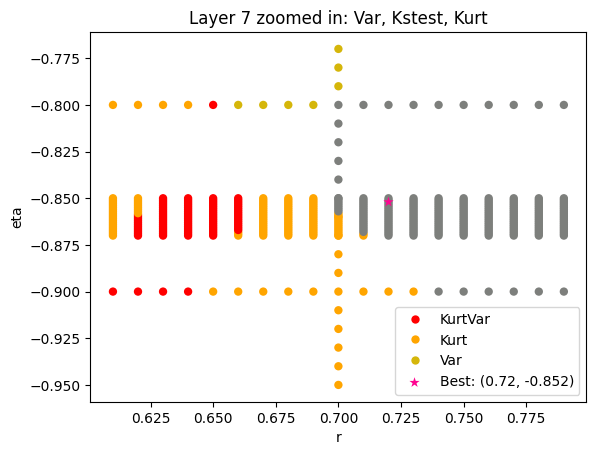

Layer 8
(1.1, -1.172), 450 of 840
(1.3, -1.164), 500 of 840
(1.6, -1.177), 550 of 840
(1.8, -1.169), 600 of 840
(2.0, -1.161), 650 of 840
(2.3, -1.174), 700 of 840
(2.5, -1.166), 750 of 840
(2.8, -1.179), 800 of 840


100%|██████████| 840/840 [00:02<00:00, 282.80it/s]


Finding Minimum after computing 840 CDFs
Iter 1 layer 8 best parameters: ((1.9, -1.169), 0.03349869450555332)


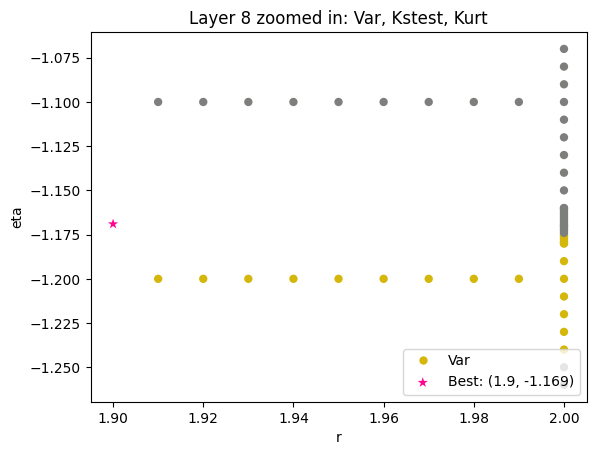

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0,best_r,best_eta,kstest_stat_best,iter1_r,iter1_eta,kstest_stat_iter1,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,1830.934600,1652.097695,2023.443611,2.933956,1.846394,4.126087,3180.0,0.34,2.40,0.017569,0.024030,0.049518,0.25,0.340,2.420,0.016925,0.340,2.420,0.016925,6787
3,587.781860,556.332090,620.660589,2.604501,2.026208,3.270645,12720.0,0.35,1.50,0.006195,0.012029,0.032488,0.27,0.353,1.560,0.005072,0.353,1.560,0.005072,72444
4,164.606740,154.984480,174.518847,3.278817,2.623241,4.093913,50880.0,0.36,0.50,0.006368,0.006018,0.015027,0.32,0.361,0.530,0.004837,0.361,0.530,0.004837,76320
5,37.863530,35.388520,40.433692,4.789256,3.843992,5.925404,203520.0,0.40,-0.06,0.001846,0.003010,0.004988,0.41,0.400,-0.061,0.001806,0.400,-0.061,0.001806,579555
6,7.493805,6.929792,8.083942,6.740129,5.245897,8.892204,814080.0,0.45,-0.60,0.006140,0.001505,0.020233,0.63,0.458,-0.570,0.004687,0.458,-0.570,0.004687,85860
7,1.386997,1.272397,1.509542,9.084314,7.002164,12.550997,3256320.0,0.70,-0.86,0.009293,0.000753,0.050050,6.00,0.720,-0.852,0.008731,0.720,-0.852,0.008731,25440
8,0.215883,0.196152,0.238341,12.285479,8.522738,23.484665,13025280.0,2.00,-1.17,0.033516,0.000376,0.195805,6.10,1.900,-1.169,0.033499,1.900,-1.169,0.033499,1590


In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

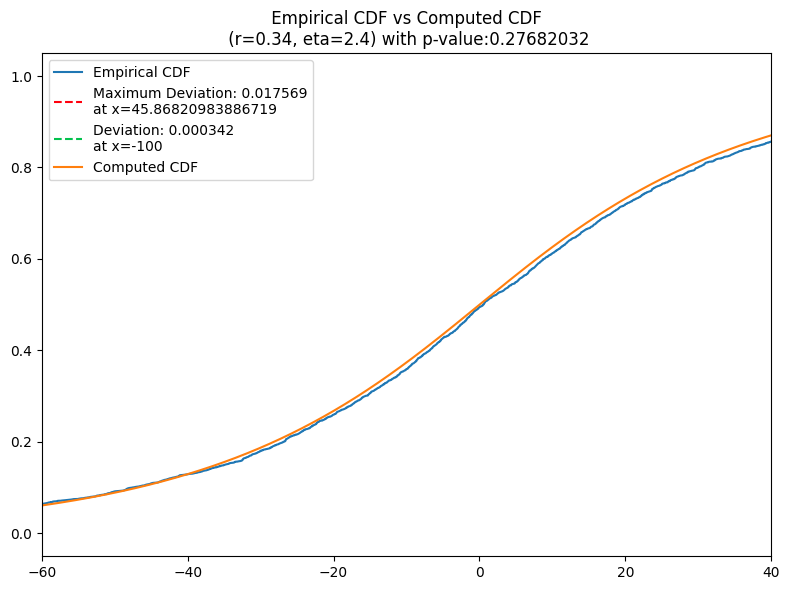

In [15]:
# Example Cell
group = 2
visualize_cdf(sample = group_data_map[group], 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

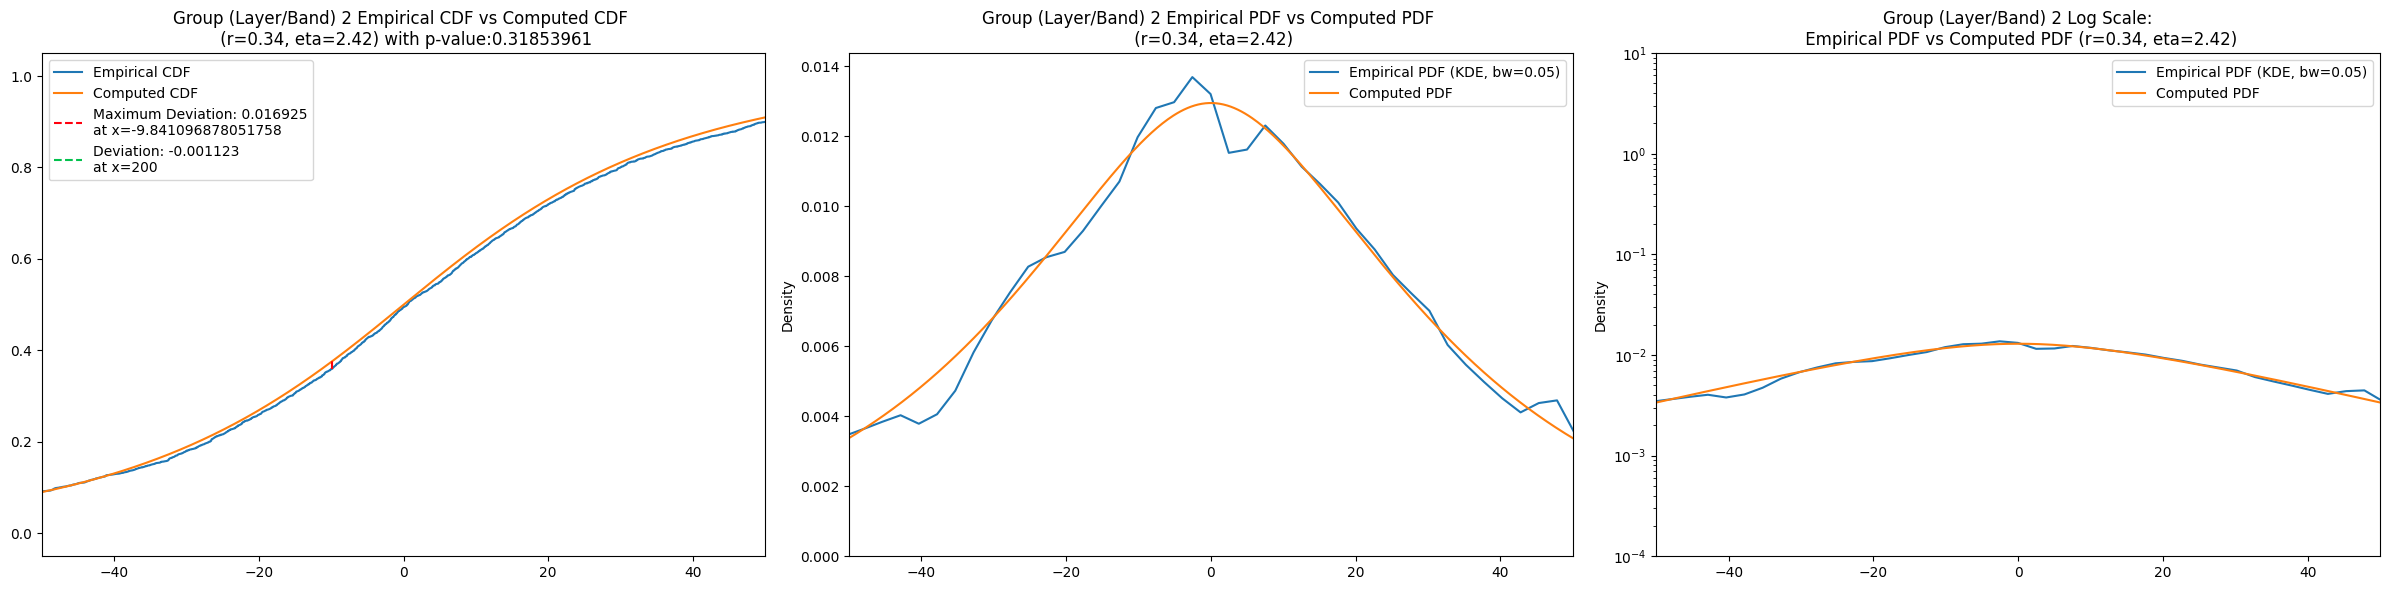

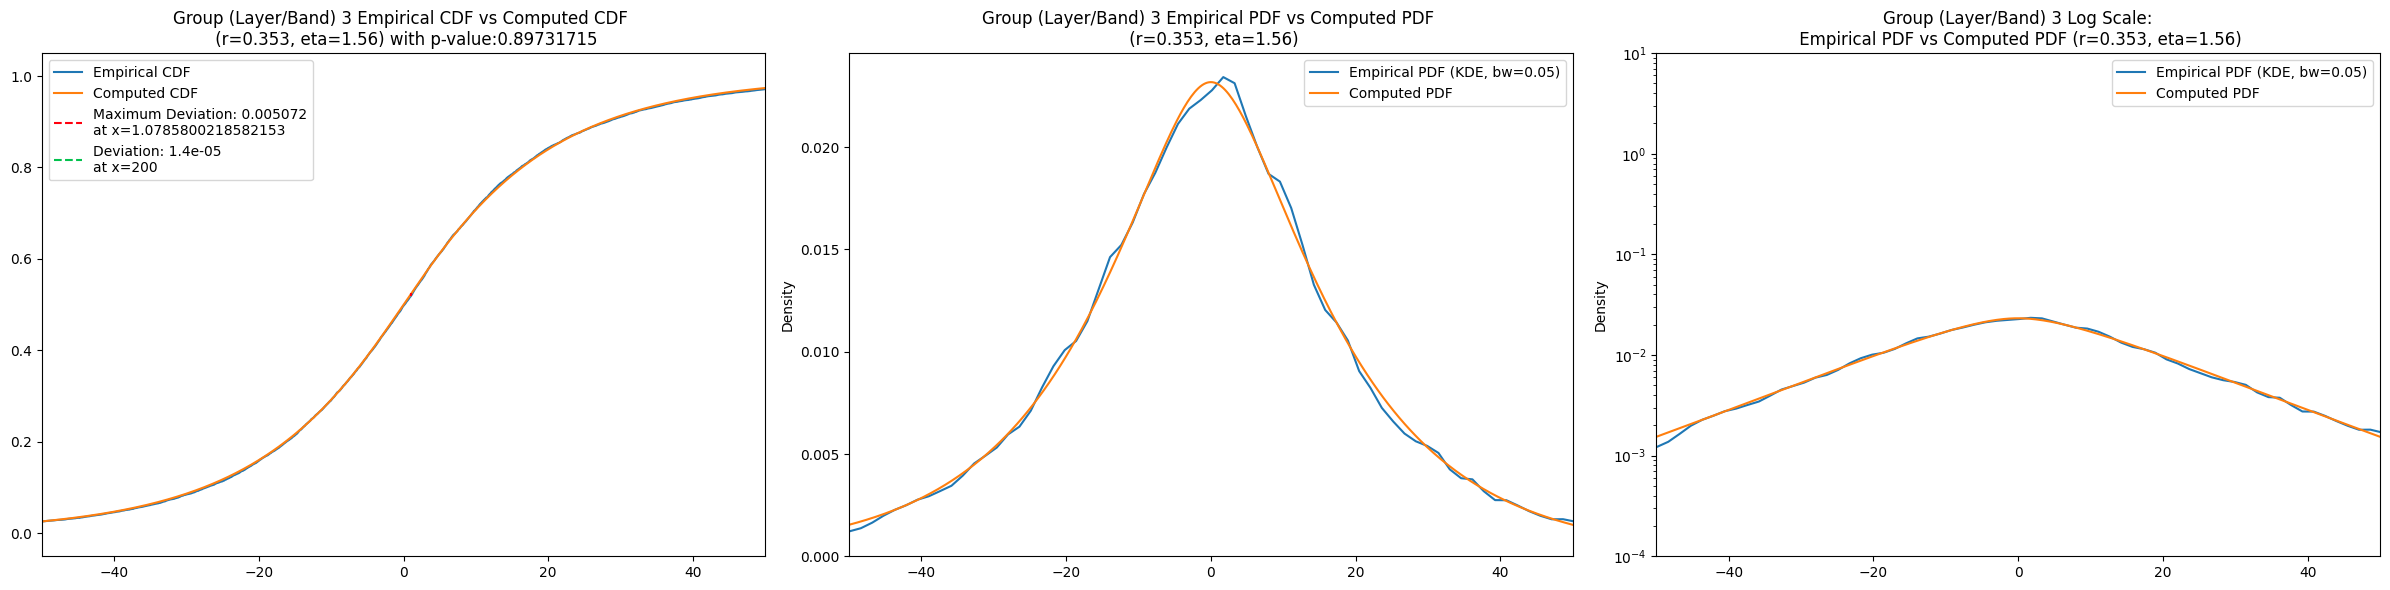

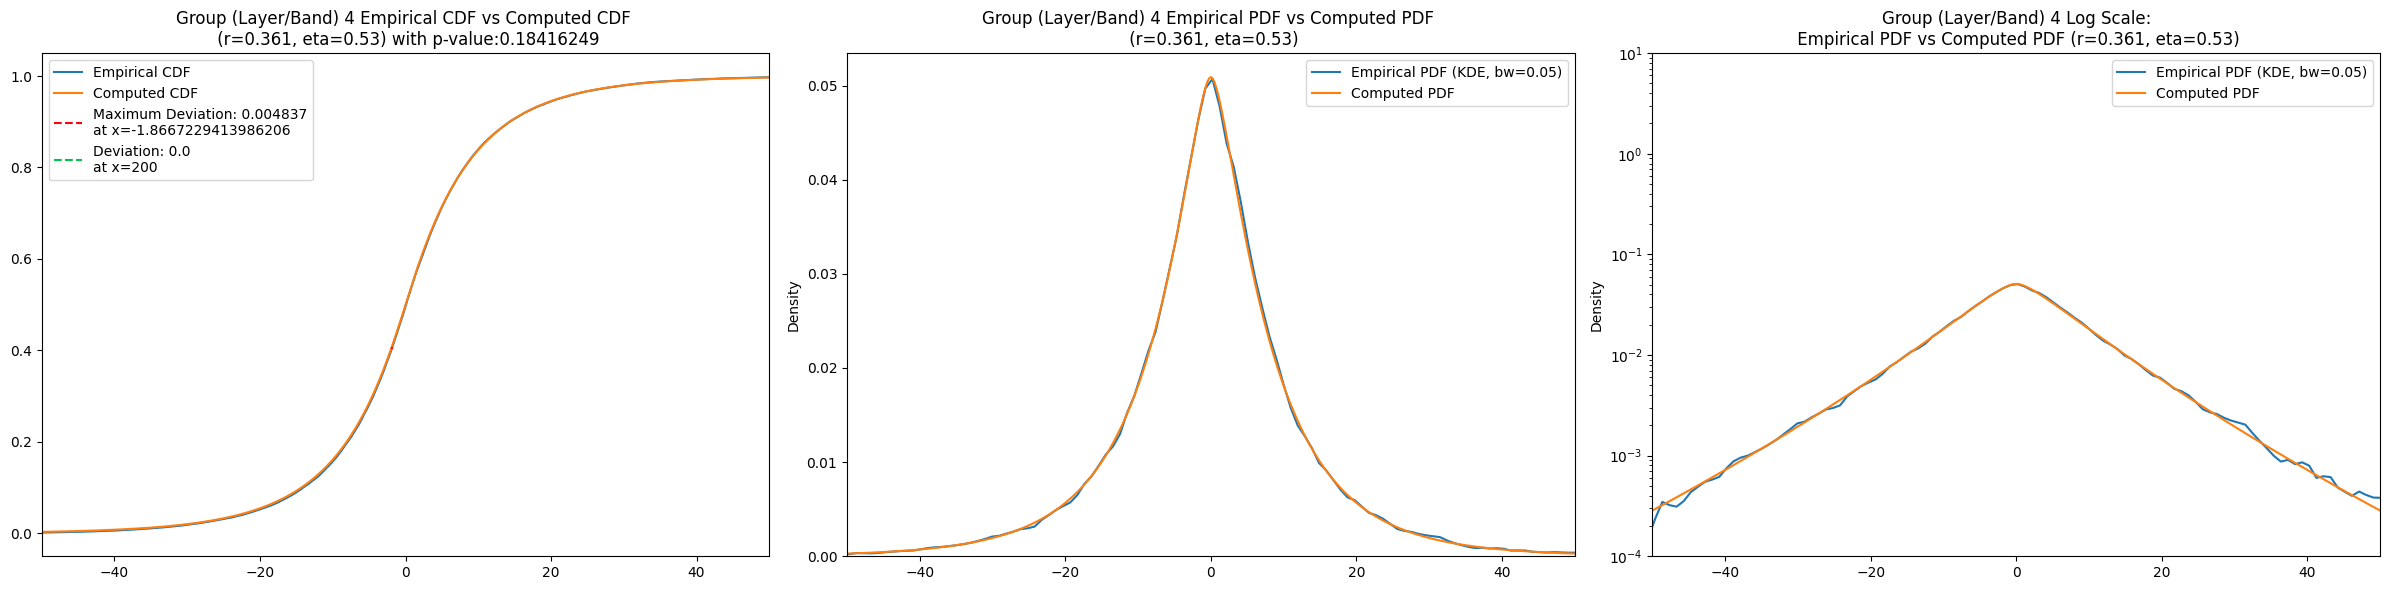

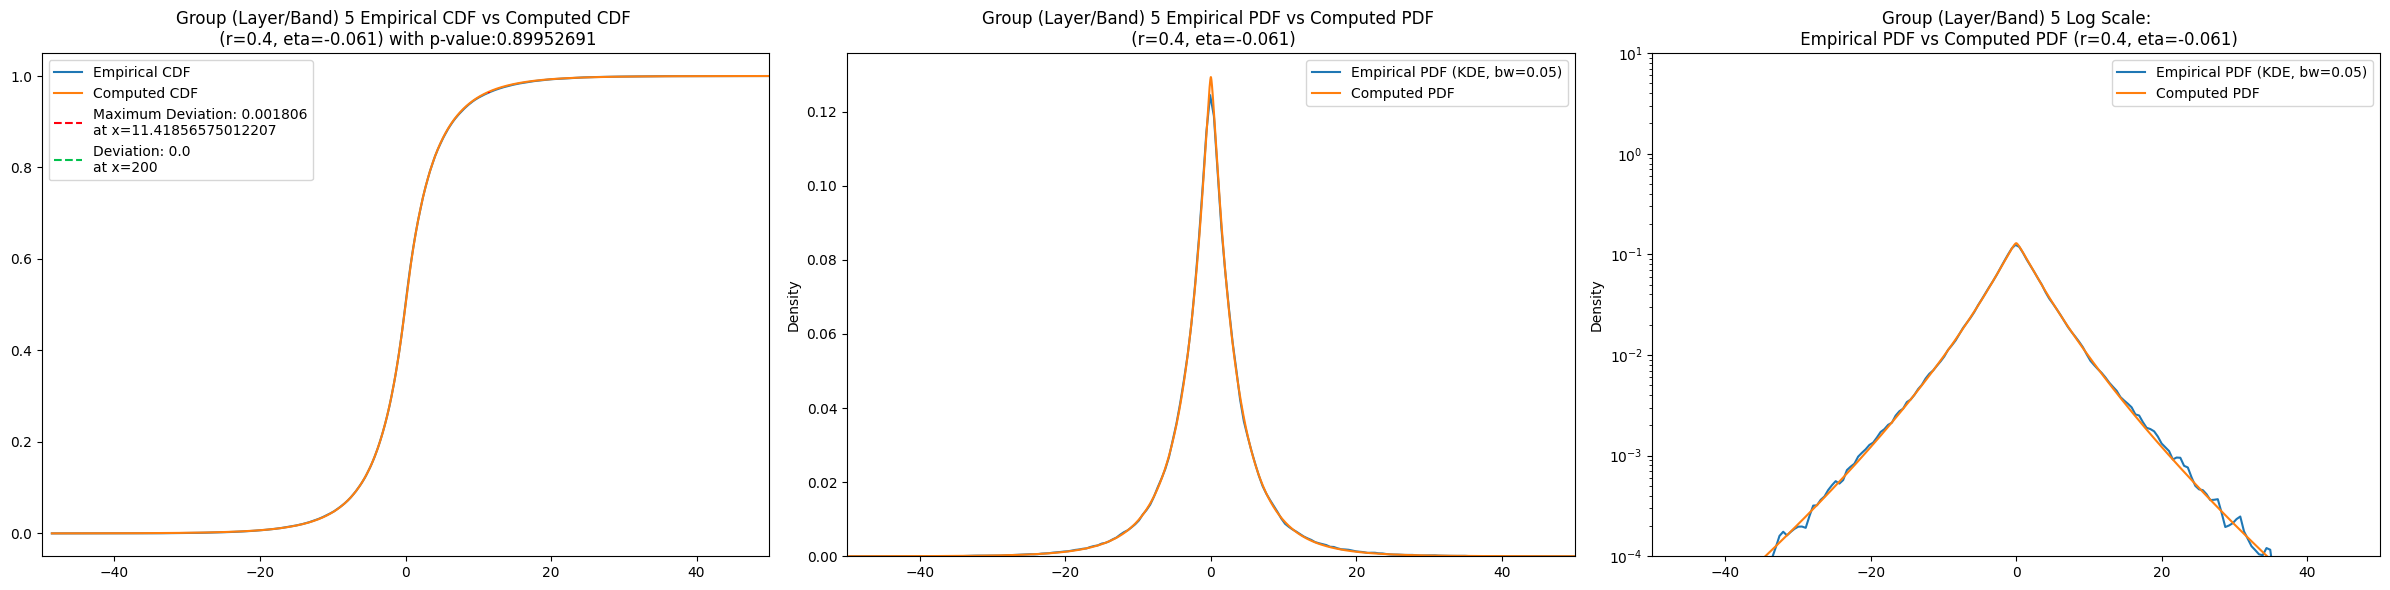

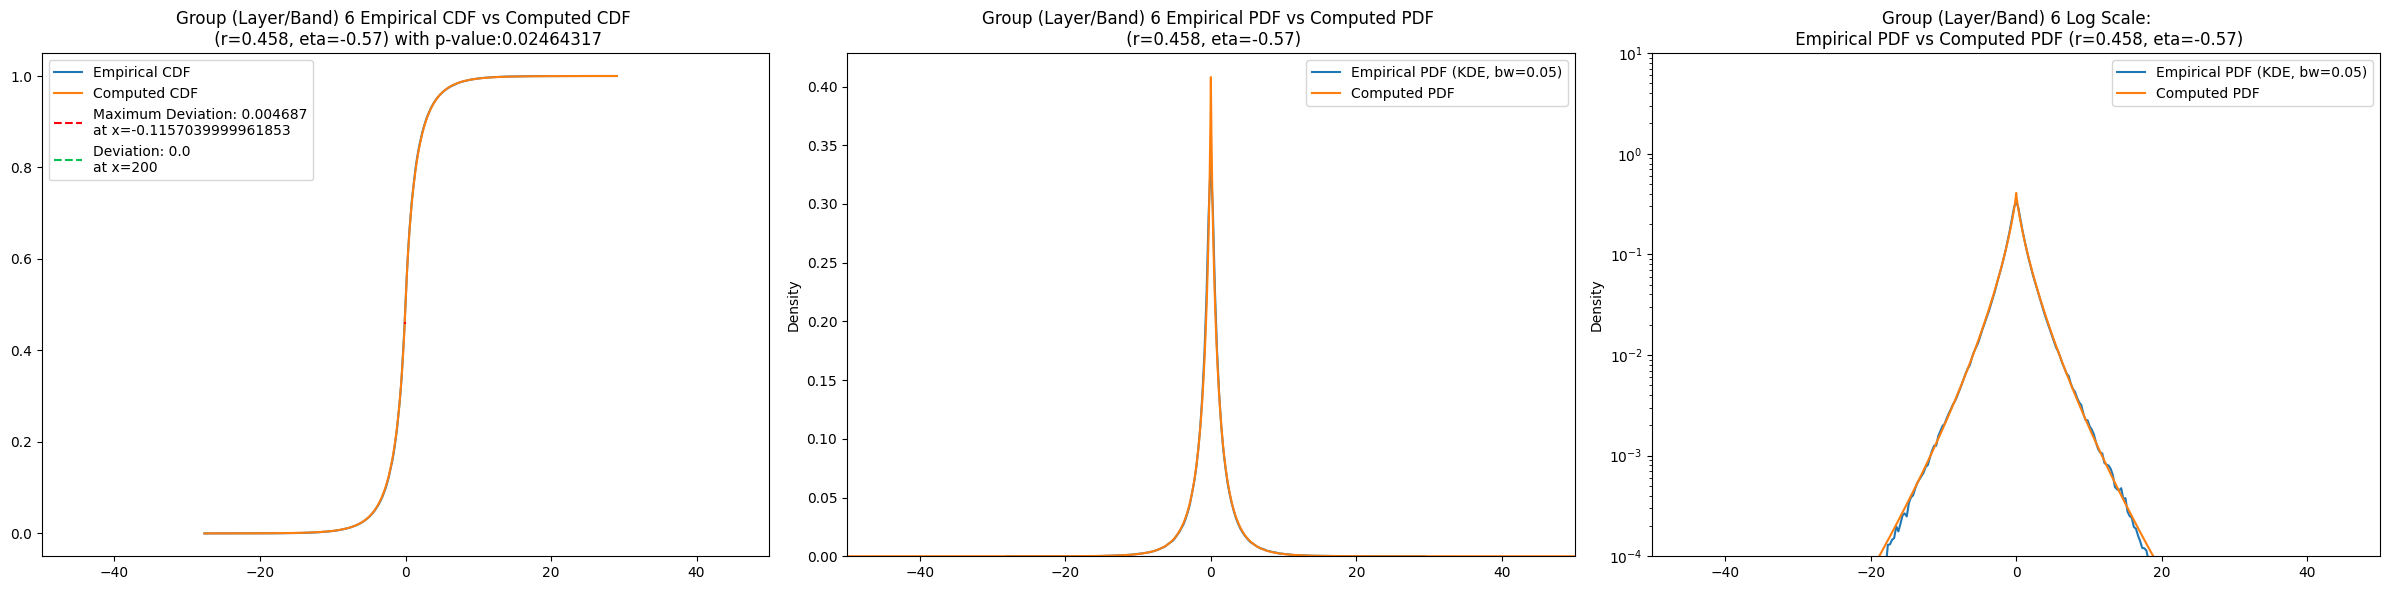

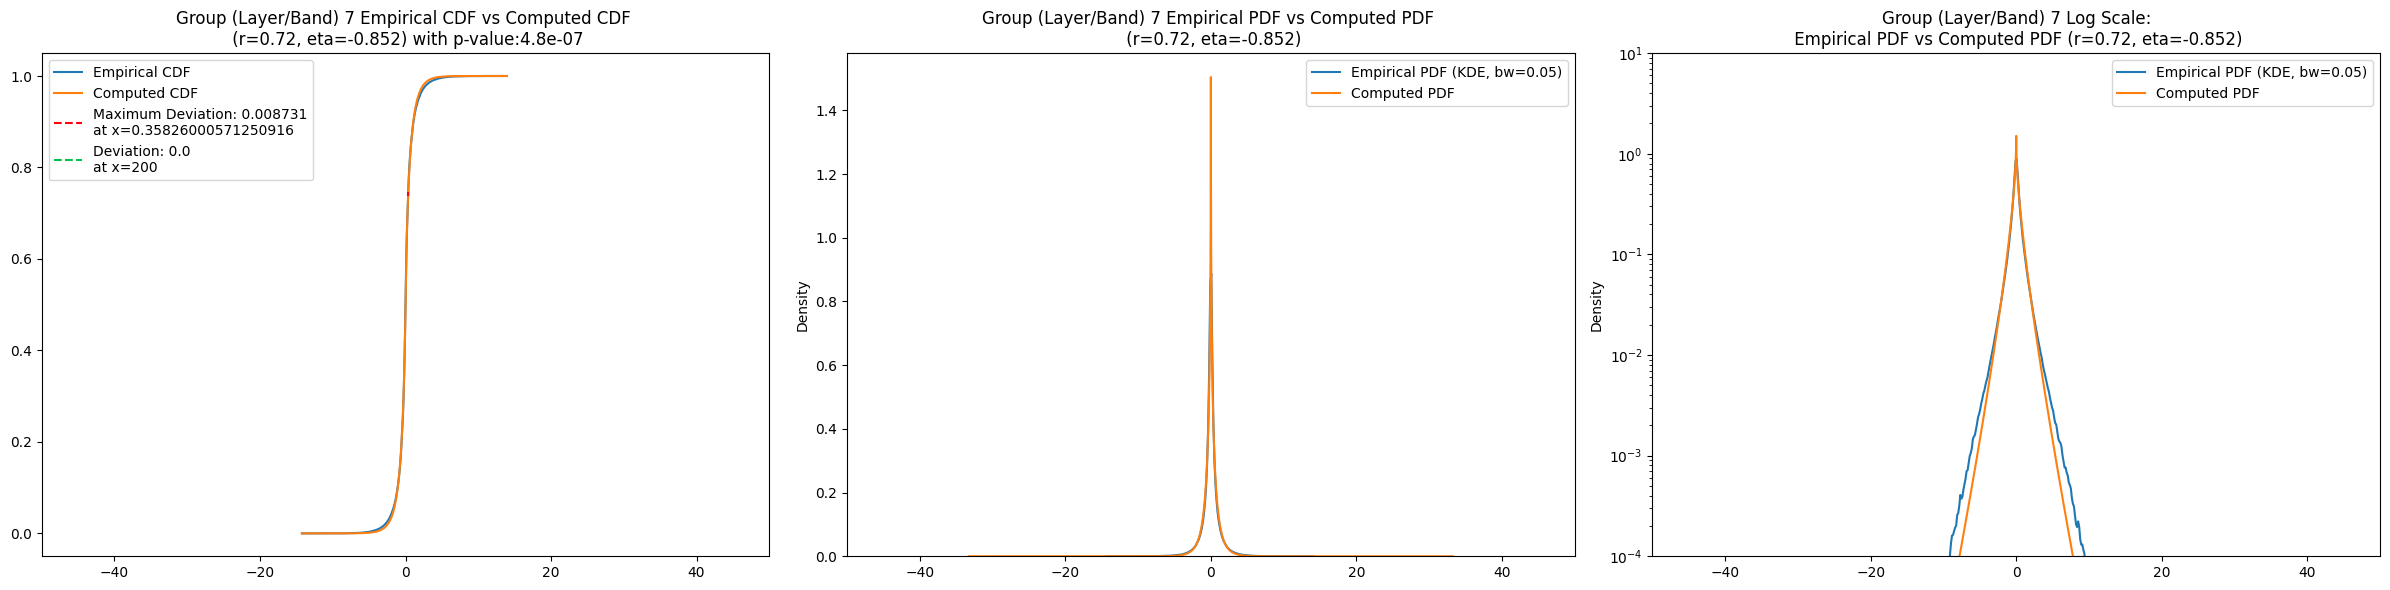

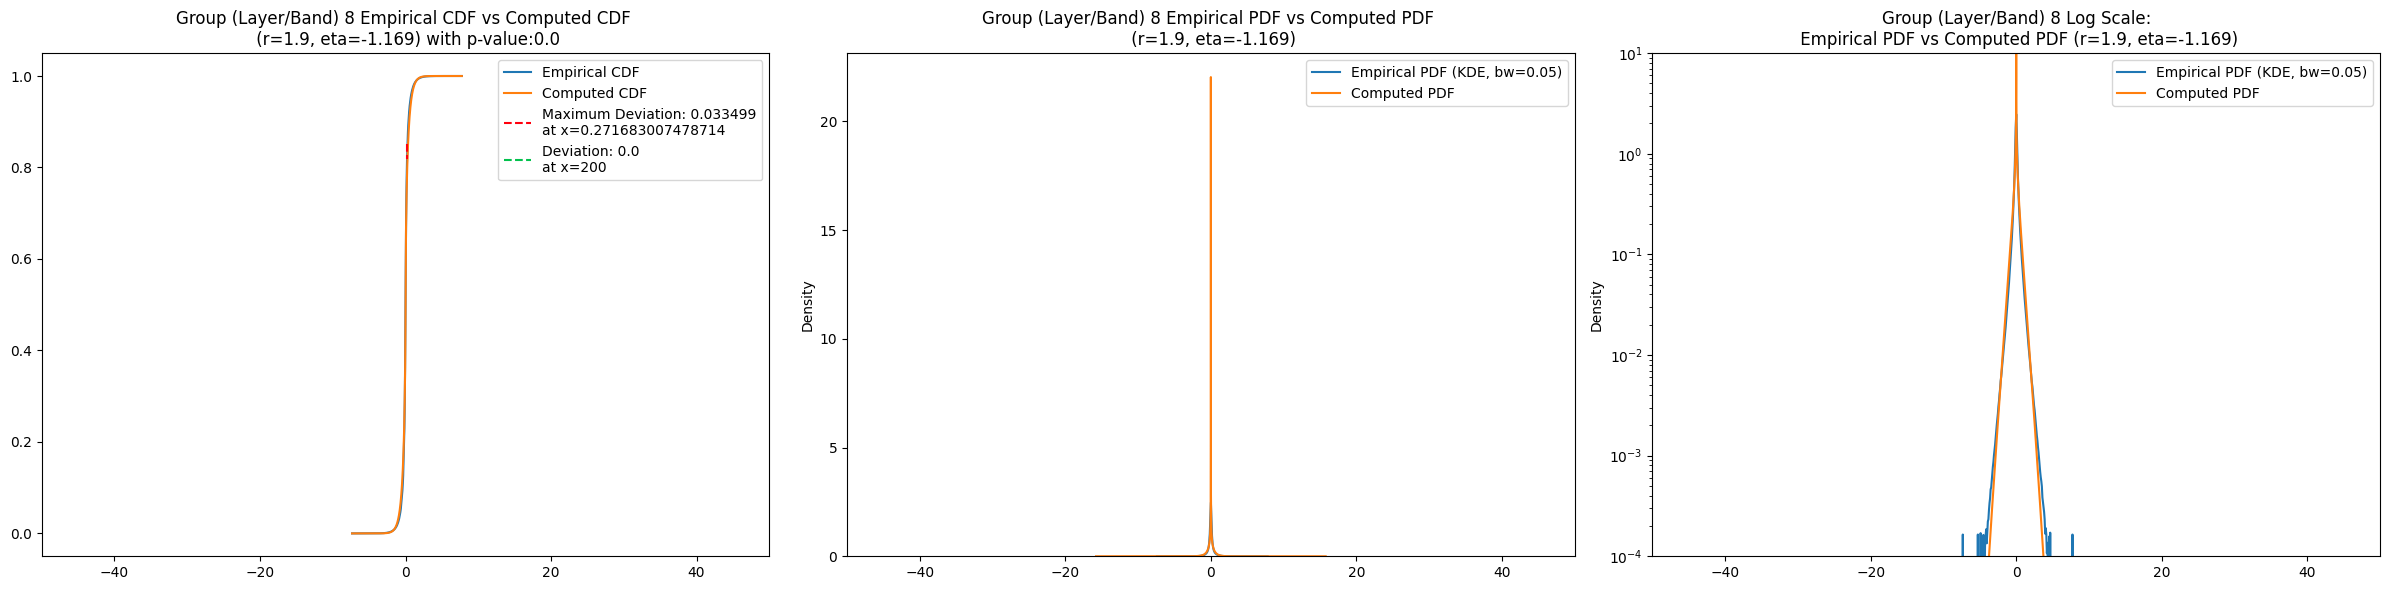

In [22]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-50, 50),
                    provided_loc=200)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,1830.934600,1652.097695,2023.443611,2.933956,1.846394,4.126087,3180.0,0.34,2.40,0.017569,...,35.216400,0.031319,3.822010e-03,32.501200,0.024581,4.216010e-02,26.626000,0.019259,1.864510e-01,3.185396e-01
3,587.781860,556.332090,620.660589,2.604501,2.026208,3.270645,12720.0,0.35,1.50,0.006195,...,20.655700,0.024528,4.427450e-07,18.039900,0.011071,8.783090e-02,14.504400,0.013417,2.033730e-02,8.973171e-01
4,164.606740,154.984480,174.518847,3.278817,2.623241,4.093913,50880.0,0.36,0.50,0.006368,...,10.162300,0.031252,1.316840e-43,8.964780,0.006986,1.386960e-02,7.271780,0.009676,1.446990e-04,1.841639e-01
5,37.863530,35.388520,40.433692,4.789256,3.843992,5.925404,203520.0,0.40,-0.06,0.001846,...,4.515610,0.035460,8.879240e-223,3.970110,0.008324,1.122440e-12,3.217420,0.011171,1.721960e-22,5.198715e-01
6,7.493805,6.929792,8.083942,6.740129,5.245897,8.892204,814080.0,0.45,-0.60,0.006140,...,1.793070,0.044345,0.000000e+00,1.573310,0.016709,7.339210e-198,1.264930,0.018767,1.707540e-249,5.850524e-16
7,1.386997,1.272397,1.509542,9.084314,7.002164,12.550997,3256320.0,0.70,-0.86,0.009293,...,0.681966,0.052539,0.000000e+00,0.598612,0.025074,0.000000e+00,0.477583,0.025556,0.000000e+00,4.798755e-216
8,0.215883,0.196152,0.238341,12.285479,8.522738,23.484665,13025280.0,2.00,-1.17,0.033516,...,0.251257,0.054679,0.000000e+00,0.221562,0.027676,0.000000e+00,0.175920,0.025922,0.000000e+00,0.000000e+00


In [19]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

## Results

In [20]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [23]:
master_df.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,kstest_stat_best,kstest_stat_iter1,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,,,,
2,3180.0,0.017569,0.024030,0.049518,0.016925,0.016925,0.031319,0.024581,0.019259
3,12720.0,0.006195,0.012029,0.032488,0.005072,0.005072,0.024528,0.011071,0.013417
4,50880.0,0.006368,0.006018,0.015027,0.004837,0.004837,0.031252,0.006986,0.009676
5,203520.0,0.001846,0.003010,0.004988,0.001806,0.001806,0.035460,0.008324,0.011171
6,814080.0,0.006140,0.001505,0.020233,0.004687,0.004687,0.044345,0.016709,0.018767
7,3256320.0,0.009293,0.000753,0.050050,0.008731,0.008731,0.052539,0.025074,0.025556
8,13025280.0,0.033516,0.000376,0.195805,0.033499,0.033499,0.054679,0.027676,0.025922
